#פרוייקט גמר בלמידת מכונה - רני גיטרמן - משחק סוקובאן משולב למידה מחיזוקים

# עולם ראשון - קופסא אחת

## טעינת גוגל דרייב

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## הורדת ספריות

In [ ]:
!apt-get update
!pip install torch numpy pygame
!apt-get install -y xvfb
!pip install pyvirtualdisplay

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,607 kB]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease [24.3 kB]
Get:10 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,700 kB]
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy/main amd64 Packages [47.4 kB]
Get:13 ht

## ייבוא ספריות

In [ ]:
# For game
import pygame
import numpy as np
from collections import deque
import random
import copy
%matplotlib inline
import matplotlib.pyplot as plt


# Pytorch
import torch
import torch.nn as nn
import torch.optim as optim

# For visualization
import time
import imageio
import base64
import IPython
import pyvirtualdisplay
import matplotlib.pyplot as plt
from IPython.display import display, clear_output


# For the map generator
import ipywidgets as widgets

# For model training
from torch.utils.tensorboard import SummaryWriter
import os

pygame 2.6.1 (SDL 2.28.4, Python 3.11.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


## קוד המשחק

In [ ]:
# Initialize Pygame
pygame.init()

# Game constants
TILE_SIZE = 50
WINDOW_WIDTH = 560
WINDOW_HEIGHT = 560

# Colors
WHITE = (255, 255, 255)
BLACK = (0, 0, 0)
BROWN = (139, 69, 19)

# Create the game window
screen = pygame.display.set_mode((WINDOW_WIDTH, WINDOW_HEIGHT))
pygame.display.set_caption("Sokoban")

# Load images
box_image = pygame.image.load('/content/drive/MyDrive/sokoban/box.png')
box_image = pygame.transform.scale(box_image, (TILE_SIZE, TILE_SIZE))

player_image = pygame.image.load('/content/drive/MyDrive/sokoban/player.png')
player_image = pygame.transform.scale(player_image, (TILE_SIZE, TILE_SIZE))

# Game state representation
# 0: empty, 1: wall, 2: box, 3: target, 4: player, 5: box on target, 6: player on target
initial_state = np.array([
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
    [1, 0, 0, 0, 0, 0, 0, 3, 0, 0, 1],
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
    [1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1],
    [1, 0, 0, 0, 4, 0, 0, 0, 0, 0, 1],
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
])

game_state = initial_state.copy()

def find_player():
    return np.where((game_state == 4) | (game_state == 6))

def move_player(dx, dy):
    global game_state
    player_pos = find_player()
    x, y = player_pos[0][0], player_pos[1][0]
    new_x, new_y = x + dx, y + dy

    if game_state[new_x, new_y] in [0, 3]:  # Empty space or target
        game_state[x, y] = 3 if game_state[x, y] == 6 else 0
        game_state[new_x, new_y] = 6 if game_state[new_x, new_y] == 3 else 4
    elif game_state[new_x, new_y] in [2, 5]:  # Box or box on target
        next_x, next_y = new_x + dx, new_y + dy
        if game_state[next_x, next_y] in [0, 3]:
            game_state[x, y] = 3 if game_state[x, y] == 6 else 0
            game_state[new_x, new_y] = 6 if game_state[new_x, new_y] == 5 else 4
            game_state[next_x, next_y] = 5 if game_state[next_x, next_y] == 3 else 2

def check_fail():
    """Check if any box is stuck in an irretrievable position."""
    for y in range(1, game_state.shape[0] - 1):
        for x in range(1, game_state.shape[1] - 1):
            if game_state[y, x] in [2, 5]:  # Box or box on target
                # Check for corner traps
                if (game_state[y - 1, x] in [1, 2] and game_state[y, x - 1] in [1, 2]) or \
                   (game_state[y - 1, x] in [1, 2] and game_state[y, x + 1] in [1, 2]) or \
                   (game_state[y + 1, x] in [1, 2] and game_state[y, x - 1] in [1, 2]) or \
                   (game_state[y + 1, x] in [1, 2] and game_state[y, x + 1] in [1, 2]):
                    return True
    return False

def check_win():
    return np.all(game_state[game_state == 2] == 5)

def draw_game():
    screen.fill(WHITE)
    for y in range(game_state.shape[0]):
        for x in range(game_state.shape[1]):
            rect = pygame.Rect(x * TILE_SIZE, y * TILE_SIZE, TILE_SIZE, TILE_SIZE)
            if game_state[y, x] == 1:  # Wall
                pygame.draw.rect(screen, BROWN, rect)
                pygame.draw.rect(screen, BLACK, rect, 2)
            elif game_state[y, x] == 2:  # Box
                screen.blit(box_image, rect)
            elif game_state[y, x] == 3:  # Target
                pygame.draw.rect(screen, (0, 255, 0), rect, 2)
            elif game_state[y, x] == 4:  # Player
                screen.blit(player_image, rect)
            elif game_state[y, x] == 5:  # Box on target
                pygame.draw.rect(screen, (0, 255, 0), rect, 2)
                screen.blit(box_image, rect)
            elif game_state[y, x] == 6:  # Player on target
                pygame.draw.rect(screen, (0, 255, 0), rect, 2)
                screen.blit(player_image, rect)
    pygame.display.flip()

def main():
    global game_state
    clock = pygame.time.Clock()
    FPS = 60
    running = True

    while running:
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False
            elif event.type == pygame.KEYDOWN:
                if event.key == pygame.K_LEFT:
                    move_player(0, -1)
                elif event.key == pygame.K_RIGHT:
                    move_player(0, 1)
                elif event.key == pygame.K_UP:
                    move_player(-1, 0)
                elif event.key == pygame.K_DOWN:
                    move_player(1, 0)
                elif event.key == pygame.K_r:  # Reset the game
                    game_state = initial_state.copy()

        draw_game()

        if check_win():
            font = pygame.font.Font(None, 74)
            text = font.render("You Win!", True, BLACK)
            screen.blit(text, (WINDOW_WIDTH // 2 - text.get_width() // 2, WINDOW_HEIGHT // 2 - text.get_height() // 2))
            pygame.display.flip()
            pygame.time.wait(2000)
            game_state = initial_state.copy()

        if check_fail():
            font = pygame.font.Font(None, 74)
            text = font.render("Game Over!", True, BLACK)
            screen.blit(text, (WINDOW_WIDTH // 2 - text.get_width() // 2, WINDOW_HEIGHT // 2 - text.get_height() // 2))
            pygame.display.flip()
            pygame.time.wait(2000)
            game_state = initial_state.copy()


        clock.tick(FPS)

    pygame.quit()


## בנייה ואימון המודל

In [ ]:
# Neural Network Model
class SokobanNet(nn.Module):
    def __init__(self):
        super(SokobanNet, self).__init__()

        # Input: 9x11 board with 7 possible states (one-hot encoded)
        self.conv1 = nn.Conv2d(7, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

        # Calculate the size of flattened features
        self.fc1 = nn.Linear(64 * 9 * 11, 512)
        self.fc2 = nn.Linear(512, 4)  # 4 actions (up, down, left, right)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = x.view(x.size(0), -1)  # Flatten
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

class ReplayBuffer:
    def __init__(self, capacity=10000):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)

def preprocess_state(state):
    """Convert game state to one-hot encoded tensor"""
    processed_state = np.zeros((7, 9, 11), dtype=np.float32)
    for i in range(7):  # 7 possible states (0-6)
        processed_state[i] = (state == i).astype(np.float32)
    return torch.FloatTensor(processed_state).unsqueeze(0)

class DQNAgent:
    def __init__(self):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.policy_net = SokobanNet().to(self.device)
        self.target_net = SokobanNet().to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())

        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=0.001)
        self.memory = ReplayBuffer(capacity=50000)

        self.batch_size = 32
        self.gamma = 0.99
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.998
        self.target_update = 10
        self.steps = 0

    def select_action(self, state, training=True):
        """Select action using epsilon-greedy policy"""
        if training and random.random() < self.epsilon:
            return random.randint(0, 3)

        with torch.no_grad():
            state_tensor = preprocess_state(state).to(self.device)
            q_values = self.policy_net(state_tensor)
            return q_values.max(1)[1].item()

    def train_step(self):
        if len(self.memory) < self.batch_size:
            return None

        transitions = self.memory.sample(self.batch_size)
        batch = list(zip(*transitions))

        state_batch = torch.cat([preprocess_state(s) for s in batch[0]]).to(self.device)
        action_batch = torch.LongTensor(batch[1]).unsqueeze(1).to(self.device)
        reward_batch = torch.FloatTensor(batch[2]).to(self.device)
        next_state_batch = torch.cat([preprocess_state(s) for s in batch[3]]).to(self.device)
        done_batch = torch.FloatTensor(batch[4]).to(self.device)

        # Compute current Q values
        current_q_values = self.policy_net(state_batch).gather(1, action_batch)

        # Compute next Q values
        with torch.no_grad():
            next_q_values = self.target_net(next_state_batch).max(1)[0]
        expected_q_values = reward_batch + (1 - done_batch) * self.gamma * next_q_values

        # Compute loss and optimize
        loss = nn.MSELoss()(current_q_values, expected_q_values.unsqueeze(1))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update target network
        self.steps += 1
        if self.steps % self.target_update == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())

        # Update epsilon
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

        return loss.item()

## הכנת סביבת האימון

In [ ]:
class SokobanEnv:
    def __init__(self):
        self.initial_state = initial_state
        self.state = None
        self.action_map = {
            0: (-1, 0),  # up
            1: (1, 0),   # down
            2: (0, -1),  # left
            3: (0, 1)    # right
        }
        self.reset()

    def reset(self):
        global game_state
        game_state = self.initial_state.copy()
        self.state = game_state.copy()
        return self.state

    def step(self, action):
        global game_state
        prev_state = game_state.copy()

        # Convert action number to direction
        dx, dy = self.action_map[action]
        move_player(dx, dy)

        # Get new state
        new_state = game_state.copy()

        # Calculate reward
        reward = self._calculate_reward(prev_state, new_state)

        # Check if episode is done
        done = check_win() or check_fail()

        return new_state, reward, done

    def _calculate_reward(self, prev_state, new_state):
        # Base step penalty
        reward = -0.1

        # Get box positions
        prev_box = np.where((prev_state == 2) | (prev_state == 5))
        new_box = np.where((new_state == 2) | (new_state == 5))
        target = np.where((self.initial_state == 3))

        if len(prev_box[0]) > 0 and len(new_box[0]) > 0:
            # Calculate Manhattan distances to target
            prev_dist = abs(prev_box[0][0] - target[0][0]) + abs(prev_box[1][0] - target[1][0])
            new_dist = abs(new_box[0][0] - target[0][0]) + abs(new_box[1][0] - target[1][0])

            # Reward for moving closer to target
            if new_dist < prev_dist:
                reward += 5
            elif new_dist > prev_dist:
                reward -= 2

        # Boxes on target rewards
        prev_boxes_on_target = np.sum(prev_state == 5)
        new_boxes_on_target = np.sum(new_state == 5)
        target_delta = new_boxes_on_target - prev_boxes_on_target

        if target_delta > 0:  # Box newly placed on target
            reward += 20
        elif target_delta < 0:  # Box moved off target
            reward -= 10

        # Terminal states
        if check_win():
            reward += 100
        elif check_fail():
            reward -= 50

        return reward



def train_dqn(num_episodes, max_steps=50, save_dir='saved_models', log_dir='runs/sokoban'):
    torch.manual_seed(2)
    np.random.seed(2)
    random.seed(2)

    # Create directories if they don't exist
    os.makedirs(save_dir, exist_ok=True)
    os.makedirs(log_dir, exist_ok=True)

    # Initialize tensorboard writer
    writer = SummaryWriter(log_dir)

    env = SokobanEnv()
    agent = DQNAgent()

    episode_rewards = []
    episode_lengths = []
    best_avg_reward = float('-inf')

    for episode in range(num_episodes):
        state = env.reset()
        episode_reward = 0
        episode_loss = 0
        num_steps = 0

        for step in range(max_steps):
            # Select action
            action = agent.select_action(state)

            # Take action
            next_state, reward, done = env.step(action)

            # Store transition
            agent.memory.push(state, action, reward, next_state, done)

            # Train model
            loss = agent.train_step()
            if loss is not None:
                episode_loss += loss

            state = next_state
            episode_reward += reward
            num_steps = step + 1

            if done:
                break

        episode_rewards.append(episode_reward)
        episode_lengths.append(num_steps)

        # Calculate averages
        avg_reward = np.mean(episode_rewards[-10:])
        avg_length = np.mean(episode_lengths[-10:])
        avg_loss = episode_loss / num_steps if num_steps > 0 else 0

        # Log to tensorboard
        writer.add_scalar('Reward/Episode', episode_reward, episode)
        writer.add_scalar('Length/Episode', num_steps, episode)
        writer.add_scalar('Average_Reward/10_Episodes', avg_reward, episode)
        writer.add_scalar('Average_Length/10_Episodes', avg_length, episode)
        writer.add_scalar('Loss/Episode', avg_loss, episode)
        writer.add_scalar('Epsilon/Episode', agent.epsilon, episode)

        # Save model every 100 episodes
        if (episode + 1) % 100 == 0:
            model_path = os.path.join(save_dir, f'model_episode_{episode+1}.pth')
            torch.save({
                'episode': episode,
                'model_state_dict': agent.policy_net.state_dict(),
                'optimizer_state_dict': agent.optimizer.state_dict(),
                'epsilon': agent.epsilon,
                'reward': avg_reward
            }, model_path)
            print(f"Model saved at episode {episode + 1}")

        # Save best model
        if avg_reward > best_avg_reward:
            best_avg_reward = avg_reward
            best_model_path = os.path.join(save_dir, 'best_model.pth')
            torch.save({
                'episode': episode,
                'model_state_dict': agent.policy_net.state_dict(),
                'optimizer_state_dict': agent.optimizer.state_dict(),
                'epsilon': agent.epsilon,
                'reward': avg_reward
            }, best_model_path)

        # Print progress
        if (episode + 1) % 10 == 0:
            print(f"Episode {episode + 1}")
            print(f"Average Reward: {avg_reward:.2f}")
            print(f"Average Length: {avg_length:.2f}")
            print(f"Epsilon: {agent.epsilon:.2f}")
            print(f"Loss: {avg_loss:.4f}")
            print("--------------------")

    writer.close()
    return agent, episode_rewards, episode_lengths

## אתחול ואימון הסוכן

Episode 10
Average Reward: 6.40
Average Length: 50.00
Epsilon: 0.39
Loss: 0.7469
--------------------
Episode 20
Average Reward: 9.10
Average Length: 50.00
Epsilon: 0.14
Loss: 1.9220
--------------------
Episode 30
Average Reward: -0.80
Average Length: 50.00
Epsilon: 0.05
Loss: 1.0543
--------------------
Episode 40
Average Reward: 12.70
Average Length: 50.00
Epsilon: 0.02
Loss: 0.7779
--------------------
Episode 50
Average Reward: 15.80
Average Length: 50.00
Epsilon: 0.01
Loss: 0.4000
--------------------
Episode 60
Average Reward: 22.00
Average Length: 50.00
Epsilon: 0.01
Loss: 0.2163
--------------------
Episode 70
Average Reward: -2.40
Average Length: 50.00
Epsilon: 0.01
Loss: 0.2546
--------------------
Episode 80
Average Reward: -4.00
Average Length: 50.00
Epsilon: 0.01
Loss: 0.0867
--------------------
Episode 90
Average Reward: 18.00
Average Length: 50.00
Epsilon: 0.01
Loss: 0.0566
--------------------
Model saved at episode 100
Episode 100
Average Reward: 23.00
Average Length

<ipython-input-12-200471049a71>:82: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done_batch = torch.FloatTensor(batch[4]).to(self.device)


Episode 490
Average Reward: 122.24
Average Length: 22.60
Epsilon: 0.01
Loss: 5.4072
--------------------
Model saved at episode 500
Episode 500
Average Reward: 122.98
Average Length: 20.20
Epsilon: 0.01
Loss: 0.5328
--------------------
Episode 510
Average Reward: 149.20
Average Length: 8.00
Epsilon: 0.01
Loss: 9.4198
--------------------
Episode 520
Average Reward: 149.14
Average Length: 8.60
Epsilon: 0.01
Loss: 18.6083
--------------------
Episode 530
Average Reward: 149.20
Average Length: 8.00
Epsilon: 0.01
Loss: 1.5599
--------------------
Episode 540
Average Reward: 135.66
Average Length: 18.40
Epsilon: 0.01
Loss: 4.5667
--------------------
Episode 550
Average Reward: 148.57
Average Length: 14.30
Epsilon: 0.01
Loss: 0.6214
--------------------
Episode 560
Average Reward: 148.98
Average Length: 10.20
Epsilon: 0.01
Loss: 10.0850
--------------------
Episode 570
Average Reward: 149.20
Average Length: 8.00
Epsilon: 0.01
Loss: 18.2595
--------------------
Episode 580
Average Reward: 1

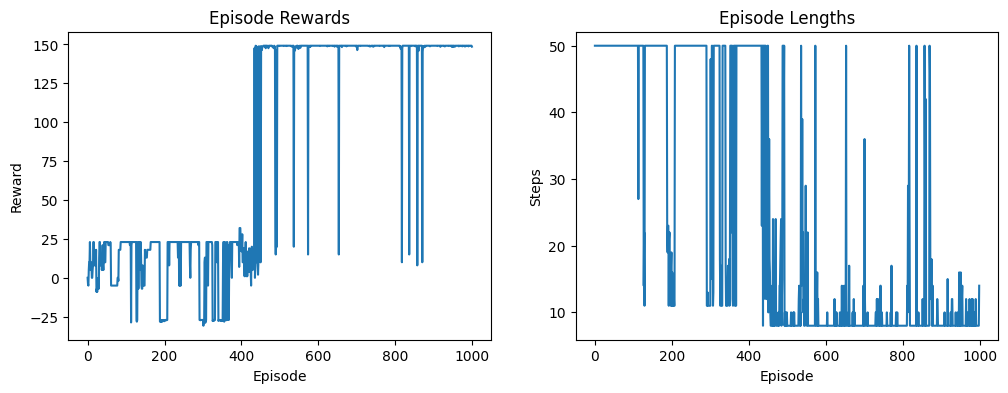

In [ ]:
# Run training
agent_one_box, rewards, lengths = train_dqn(num_episodes=1000, save_dir='saved_models_one_box')

# Plot training progress
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(rewards)
plt.title('Episode Rewards')
plt.xlabel('Episode')
plt.ylabel('Reward')

plt.subplot(1, 2, 2)
plt.plot(lengths)
plt.title('Episode Lengths')
plt.xlabel('Episode')
plt.ylabel('Steps')
plt.show()

## טעינת המודל הטוב ביותר

In [ ]:
# To load a saved model:
def load_model(model_path, agent):
    checkpoint = torch.load(model_path, weights_only=False)
    agent.policy_net.load_state_dict(checkpoint['model_state_dict'])
    agent.target_net.load_state_dict(checkpoint['model_state_dict'])
    agent.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    agent.epsilon = checkpoint['epsilon']
    return agent, checkpoint['episode'], checkpoint['reward']

In [ ]:
# To load the best model:
# agent_one_box, episode, reward = load_model('saved_models_one_box/best_model.pth', agent_one_box)

# To load the best model, saved in Drive for presentation:
agent_one_box, episode, reward = load_model('/content/drive/MyDrive/sokoban/best_model.pth', DQNAgent())
print(f"Loaded the best model! Episode {episode} with reward {reward}")

Loaded the best model! Episode 200 with reward 149.36000000000004


## וויזואליזציה

In [ ]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

def record_agent_gameplay(agent, video_filename):
   global game_state
   done = False
   iter = 0
   total_reward = 0
   num_of_steps = 0
   start_time = time.time()

   game_state = initial_state.copy()

   with imageio.get_writer(video_filename, fps=10) as video:
       # Capture initial state
       draw_game()
       pygame_surface = screen.copy()
       frame = pygame.surfarray.array3d(pygame_surface)
       frame = np.transpose(frame, (1, 0, 2))
       video.append_data(frame)

       while (iter < 10) or not done:
           time_passed = int(time.time() - start_time)
           if done or time_passed > 5:
               break

           iter += 1
           num_of_steps += 1

           # Get agent action and execute
           action = agent.select_action(game_state, training=False)
           dx, dy = {0: (-1, 0), 1: (1, 0), 2: (0, -1), 3: (0, 1)}[action]
           move_player(dx, dy)

           # Capture frame
           draw_game()
           pygame_surface = screen.copy()
           frame = pygame.surfarray.array3d(pygame_surface)
           frame = np.transpose(frame, (1, 0, 2))
           video.append_data(frame)

           done = check_win() or check_fail()

   print(f"Steps taken: {num_of_steps}")
   return embed_mp4(video_filename)

In [ ]:
  # Usage
record_agent_gameplay(agent_one_box, 'one_box.mp4')

# עולם שני - שתי קופסאות

## אתחול המפה החדשה

In [ ]:
initial_state = np.array([
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
    [1, 0, 0, 0, 2, 3, 0, 0, 0, 0, 1],
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
    [1, 0, 0, 0, 4, 0, 0, 0, 0, 0, 1],
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
    [1, 0, 0, 0, 0, 3, 2, 0, 0, 0, 1],
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
])

## אתחול ואימון הסוכן

Episode 10
Average Reward: 0.90
Average Length: 50.00
Epsilon: 0.39
Loss: 15.1132
--------------------
Episode 20
Average Reward: 7.00
Average Length: 50.00
Epsilon: 0.14
Loss: 2.9479
--------------------
Episode 30
Average Reward: 8.20
Average Length: 50.00
Epsilon: 0.05
Loss: 2.8714
--------------------
Episode 40
Average Reward: 17.20
Average Length: 50.00
Epsilon: 0.02
Loss: 0.9768
--------------------
Episode 50
Average Reward: 13.50
Average Length: 50.00
Epsilon: 0.01
Loss: 0.7038
--------------------
Episode 60
Average Reward: 12.90
Average Length: 50.00
Epsilon: 0.01
Loss: 0.5266
--------------------
Episode 70
Average Reward: 9.80
Average Length: 50.00
Epsilon: 0.01
Loss: 0.3514
--------------------
Episode 80
Average Reward: 22.32
Average Length: 46.80
Epsilon: 0.01
Loss: 4.3065
--------------------
Episode 90
Average Reward: 12.00
Average Length: 50.00
Epsilon: 0.01
Loss: 2.1449
--------------------


<ipython-input-12-200471049a71>:82: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done_batch = torch.FloatTensor(batch[4]).to(self.device)


Model saved at episode 100
Episode 100
Average Reward: 16.20
Average Length: 47.00
Epsilon: 0.01
Loss: 7.0839
--------------------
Episode 110
Average Reward: 94.10
Average Length: 29.00
Epsilon: 0.01
Loss: 8.7137
--------------------
Episode 120
Average Reward: 112.68
Average Length: 31.20
Epsilon: 0.01
Loss: 5.7579
--------------------
Episode 130
Average Reward: 142.68
Average Length: 23.20
Epsilon: 0.01
Loss: 2.0963
--------------------
Episode 140
Average Reward: 40.37
Average Length: 46.30
Epsilon: 0.01
Loss: 1.8358
--------------------
Episode 150
Average Reward: 78.80
Average Length: 35.00
Epsilon: 0.01
Loss: 3.9340
--------------------
Episode 160
Average Reward: 143.62
Average Length: 13.80
Epsilon: 0.01
Loss: 2.2121
--------------------
Episode 170
Average Reward: 143.50
Average Length: 15.00
Epsilon: 0.01
Loss: 2.5418
--------------------
Episode 180
Average Reward: 143.52
Average Length: 14.80
Epsilon: 0.01
Loss: 2.3457
--------------------
Episode 190
Average Reward: 143.

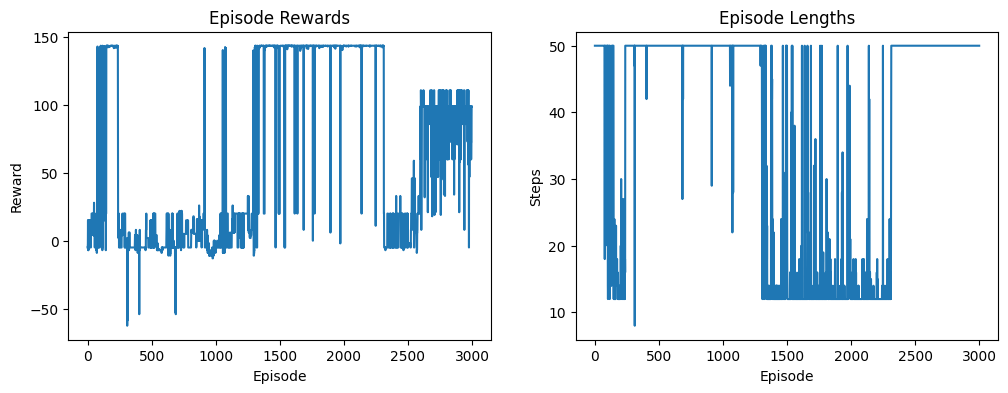

In [ ]:
# Run training
agent_two_box, rewards, lengths = train_dqn(num_episodes=3000, save_dir='saved_models_two_box')

# Plot training progress
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(rewards)
plt.title('Episode Rewards')
plt.xlabel('Episode')
plt.ylabel('Reward')

plt.subplot(1, 2, 2)
plt.plot(lengths)
plt.title('Episode Lengths')
plt.xlabel('Episode')
plt.ylabel('Steps')
plt.show()

## טעינת המודל הטוב ביותר

In [ ]:
# To load a saved model:
def load_model(model_path, agent):
    checkpoint = torch.load(model_path)
    agent.policy_net.load_state_dict(checkpoint['model_state_dict'])
    agent.target_net.load_state_dict(checkpoint['model_state_dict'])
    agent.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    agent.epsilon = checkpoint['epsilon']
    return agent, checkpoint['episode'], checkpoint['reward']

In [ ]:
# To load the best model:
agent_two_box, episode, reward = load_model('saved_models_two_box/best_model.pth', agent_two_box)
print(f"Loaded the best model! Episode {episode} with reward {reward}")

Loaded the best model! Episode 1354 with reward 143.79999999999998


<ipython-input-28-3c400c0571e3>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


## וויזואליזציה

In [ ]:
# Usage
record_agent_gameplay(agent_two_box, 'two_box.mp4')

Steps taken: 12


# יצירת עולם דינמי

In [ ]:
from IPython.display import display, clear_output

def create_sokoban_map():
    # Initialize empty grid (9x11 with walls)
    grid = np.ones((9, 11))  # All walls initially
    grid[1:-1, 1:-1] = 0  # Empty inside

    # Create buttons for each cell
    buttons = {}
    for i in range(9):
        for j in range(11):
            buttons[(i,j)] = widgets.Button(
                description='',
                layout=widgets.Layout(width='40px', height='40px'),
                disabled=i==0 or i==8 or j==0 or j==10  # Disable border buttons
            )

    # Create tile selection buttons
    tile_types = {
        0: ('Empty', 'white'),
        1: ('Wall', 'brown'),
        2: ('Box', 'orange'),
        3: ('Target', 'lightgreen'),
        4: ('Player', 'lightblue')
    }

    selected_tile = widgets.RadioButtons(
        options=[(name, val) for val, (name, _) in tile_types.items()],
        description='Tile:',
        layout={'width': 'max-content'}
    )

    def update_button_colors():
        for i in range(9):
            for j in range(11):
                val = int(grid[i,j])
                buttons[(i,j)].style.button_color = tile_types[val][1]

    def on_cell_click(i, j):
        def handle_click(b):
            nonlocal grid
            if selected_tile.value == 4:  # If placing player, remove old player
                player_pos = np.where(grid == 4)
                if len(player_pos[0]) > 0:
                    grid[player_pos] = 0
            grid[i,j] = selected_tile.value
            update_button_colors()
        return handle_click

    # Assign click handlers
    for i in range(9):
        for j in range(11):
            if not (i==0 or i==8 or j==0 or j==10):  # Skip borders
                buttons[(i,j)].on_click(on_cell_click(i,j))

    # Create grid layout
    grid_layout = widgets.GridBox(
        [buttons[(i,j)] for i in range(9) for j in range(11)],
        layout=widgets.Layout(
            grid_template_columns='repeat(11, 40px)',
            grid_gap='1px'
        )
    )

    def get_array(b):
        print("Map created successfully!")
        print("initial_state = np.array([")
        for row in grid:
            print("    [" + ", ".join(map(str, map(int, row))) + "],")
        print("])")

    get_array_button = widgets.Button(description='Create map')
    get_array_button.on_click(get_array)

    # Initialize colors
    update_button_colors()

    # Display everything
    display(widgets.VBox([
        widgets.HTML('<h3>Sokoban Map Creator</h3>'),
        selected_tile,
        grid_layout,
        get_array_button
    ]))

    return grid

# Usage:
initial_state = create_sokoban_map()

Map created successfully!
initial_state = np.array([
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
    [1, 0, 0, 0, 0, 4, 0, 0, 0, 0, 1],
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
    [1, 0, 0, 3, 2, 0, 2, 3, 0, 0, 1],
    [1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1],
    [1, 0, 0, 0, 0, 3, 0, 0, 0, 0, 1],
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
])


## אתחול ואימון הסוכן

Episode 10
Average Reward: 1.79
Average Length: 48.10
Epsilon: 0.41
Loss: 7.5956
--------------------
Episode 20
Average Reward: 24.40
Average Length: 48.00
Epsilon: 0.16
Loss: 35.2285
--------------------


<ipython-input-12-200471049a71>:82: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done_batch = torch.FloatTensor(batch[4]).to(self.device)


Episode 30
Average Reward: 54.46
Average Length: 43.40
Epsilon: 0.07
Loss: 30.7017
--------------------
Episode 40
Average Reward: 47.78
Average Length: 43.20
Epsilon: 0.03
Loss: 10.4861
--------------------
Episode 50
Average Reward: 76.86
Average Length: 34.40
Epsilon: 0.01
Loss: 18.4333
--------------------
Episode 60
Average Reward: 121.33
Average Length: 20.70
Epsilon: 0.01
Loss: 9.0167
--------------------
Episode 70
Average Reward: 134.06
Average Length: 16.40
Epsilon: 0.01
Loss: 4.7554
--------------------
Episode 80
Average Reward: 120.99
Average Length: 25.10
Epsilon: 0.01
Loss: 7.6461
--------------------
Episode 90
Average Reward: 104.91
Average Length: 25.90
Epsilon: 0.01
Loss: 5.4809
--------------------
Model saved at episode 100
Episode 100
Average Reward: 70.72
Average Length: 32.80
Epsilon: 0.01
Loss: 4.6415
--------------------
Episode 110
Average Reward: 164.20
Average Length: 8.00
Epsilon: 0.01
Loss: 5.7571
--------------------
Episode 120
Average Reward: 164.20
Av

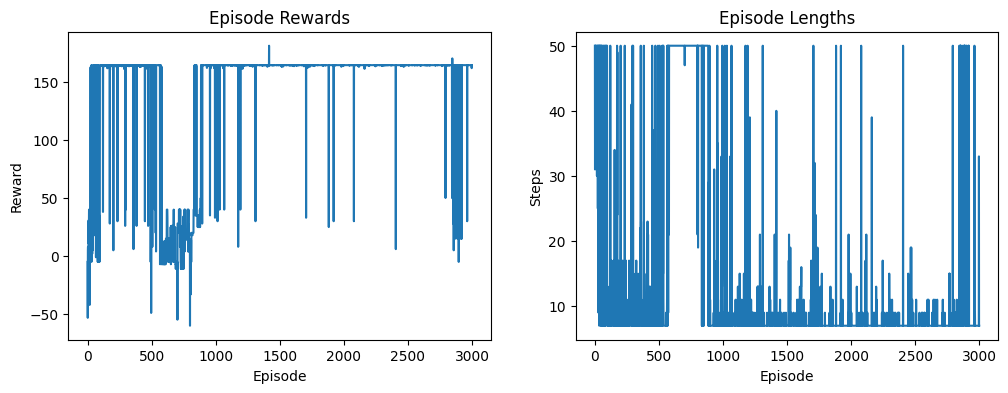

In [ ]:
# Run training
agent_dynamic, rewards, lengths = train_dqn(num_episodes=3000, save_dir='saved_models_dynamic_box')

# Plot training progress
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(rewards)
plt.title('Episode Rewards')
plt.xlabel('Episode')
plt.ylabel('Reward')

plt.subplot(1, 2, 2)
plt.plot(lengths)
plt.title('Episode Lengths')
plt.xlabel('Episode')
plt.ylabel('Steps')
plt.show()

## וויזואליזציה

In [ ]:
record_agent_gameplay(agent_dynamic, 'dynamic_box.mp4')

Steps taken: 7
